<a href="https://colab.research.google.com/github/CesarAugusto88/PDI/blob/main/Neurocomputa%C3%A7%C3%A3o_Segmention_and_Classification_Regression_(13_07_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neurocomputação
## Prof. Marcos G. Quiles
### Cesar Augusto de Moraes Costa





In [131]:
# importing data
!gdown --id 1A1PdLYZ8C-WeM1MlWLv6dSj2yZR8Bu7S
!gdown --id 1dFAiKUhjmsZVny52Kaxo6PJBZm5EbnY4
!gdown --id 1XbyaBGzYoGQLCKa-4PAbEuA7Doue0s0i
!gdown --id 146c83uOEy-ep_PtoRXiReLSGX68lM6T5
!gdown --id 1ManUn9-sOVYbDcsGSEcMFDQqt6LnbS4y

!gdown --id 139XYm5irDHy3QBwBxJmat9PNCe3gWozQ
!gdown --id 1zglwC24nnUPrufNOFLq2xhI6vv0yTYfm
!gdown --id 1iy3s4CLZuou979MUbkU2QO76ViqZdkPn
!gdown --id 1HkKxnYdjID28xJD8vD0SHqOVwdiqs4GB
!gdown --id 1bYrIXqPRqxXo2Z7cA4P7laHolHku9LQW

# pansharpening
!gdown --id 1ER7V68nXfx28vzDNpCrIG1Ev8iIbIwHt

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1A1PdLYZ8C-WeM1MlWLv6dSj2yZR8Bu7S
To: /content/pan_recorte.shp
100% 24.6M/24.6M [00:00<00:00, 108MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dFAiKUhjmsZVny52Kaxo6PJBZm5EbnY4
To: /content/pan_recorte.shx
100% 1.38M/1.38M [00:00<00:00, 32.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
Fr

In [132]:
# install libraries
# !nvidia-smi # GPU
!pip install geopandas
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdal
import ogr
from numpy import MAXDIMS

from skimage import exposure
from skimage.segmentation import quickshift, slic
from skimage import segmentation
import time
import scipy
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score

# Rasterize Training Data

In [134]:
# OBIA
# open NAIP image as a gdal raster dataset
# naip_fn = '/content/recorte_merge_composicao_colorida.tif' 
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
type(naip_ds)

osgeo.gdal.Dataset

In [135]:
nbands = naip_ds.RasterCount
band_data = []
print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
  band = naip_ds.GetRasterBand(i).ReadAsArray()
  band_data.append(band)
band_data = np.dstack(band_data)  # b for b in band_data
print(band_data.shape)

bands 4 rows 450 columns 554
(450, 554, 4)


In [136]:
img = exposure.rescale_intensity(band_data)

seg_start = time.time()

#segments = quickshift(img.astype("double"), convert2lab=False) # OK / agora com erro
#segments = quickshift(img.astype("double"), ratio=0.1, convert2lab=False)  # error assert com ratio>0.4
segments = slic(img, n_segments=100000, compactness=0.1)  # very good
# segments = slic(img, n_segments=500000, compactness=0.01)
#segments = quickshift(img.astype("double"), ratio=0.99, max_dist=5, convert2lab=False)
# segments = slic(img, n_segments=500000, compactness=0.1)
print('segments complete', time.time() - seg_start)

def segment_features(segment_pixels):
  features = []
  npixels, nbands = segment_pixels.shape
  for b in range(nbands):
    stats = scipy.stats.describe(segment_pixels[:,b])
    band_stats = list(stats.minmax) + list(stats)[2:]
    if npixels == 1:
      # in this case the variance = nan, change it 0.0
      band_stats[3] = 0.0
    features += band_stats
  return features

obj_start = time.time()
segment_ids = np.unique(segments)
objects = []
objects_ids = []
for id in segment_ids:
  segment_pixels = img[segments == id]
  print('pixels for id', id, segment_pixels.shape)
  object_features = segment_features(segment_pixels)
  objects.append(object_features)
  objects_ids.append(id)

print('created', len(objects), 'objects with', len(objects[0]), 'variables in',
      time.time()-obj_start, 'seconds')

# save segments to raster
segments_fn = '/content/segments.tif'
segments_ds = driverTiff.Create(segments_fn, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(naip_ds.GetGeoTransform())
segments_ds.SetProjection(naip_ds.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  import sys


Streaming output truncated to the last 5000 lines.
pixels for id 56198 (4, 4)
pixels for id 56199 (4, 4)
pixels for id 56200 (4, 4)
pixels for id 56201 (4, 4)
pixels for id 56202 (4, 4)
pixels for id 56203 (4, 4)
pixels for id 56204 (4, 4)
pixels for id 56205 (4, 4)
pixels for id 56206 (4, 4)
pixels for id 56207 (4, 4)
pixels for id 56208 (4, 4)
pixels for id 56209 (4, 4)
pixels for id 56210 (4, 4)
pixels for id 56211 (4, 4)
pixels for id 56212 (4, 4)
pixels for id 56213 (4, 4)
pixels for id 56214 (4, 4)
pixels for id 56215 (4, 4)
pixels for id 56216 (4, 4)
pixels for id 56217 (4, 4)
pixels for id 56218 (4, 4)
pixels for id 56219 (4, 4)
pixels for id 56220 (4, 4)
pixels for id 56221 (4, 4)
pixels for id 56222 (4, 4)
pixels for id 56223 (4, 4)
pixels for id 56224 (7, 4)
pixels for id 56225 (2, 4)
pixels for id 56226 (2, 4)
pixels for id 56227 (3, 4)
pixels for id 56228 (3, 4)
pixels for id 56229 (5, 4)
pixels for id 56230 (4, 4)
pixels for id 56231 (4, 4)
pixels for id 56232 (4, 4)
pixe

In [137]:
# read shapefile to geopandas geodataframe
gdf = gpd.read_file('/content/truth_data.shp')  # pontos amostrais
gdf

,ktype,geometry
0,agua,POINT (396890.488 7439395.464)
1,agua,POINT (397012.515 7439403.851)
2,agua,POINT (396889.797 7439495.421)
3,agua,POINT (397303.494 7438938.111)
4,agua,POINT (396801.606 7438881.836)
5,agua,POINT (396982.671 7439684.670)
6,agua,POINT (397087.168 7438947.936)
7,arvore,POINT (397184.649 7439354.115)
8,arvore,POINT (397065.551 7439426.850)
9,arvore,POINT (396835.275 7439687.424)


In [138]:
# get names of land cover classes/labels
class_names = gdf['ktype'].unique()
print('class names', class_names)

class names ['agua' 'arvore' 'construcao' 'grama']


In [139]:
# create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
print('class ids', class_ids)

class ids [1 2 3 4]


In [140]:
# create a data frame of the labels and ids and save to csv
df = pd.DataFrame({'ktype': class_names, 'id': class_ids})
df.to_csv('/content/class_lookup.csv')
print('gdf without ids')
print(gdf.head())
gdf['id'] = gdf['ktype'].map(dict(zip(class_names, class_ids)))
print('gdf whith ids')
print(gdf.head())

gdf without ids
  ktype                        geometry
0  agua  POINT (396890.488 7439395.464)
1  agua  POINT (397012.515 7439403.851)
2  agua  POINT (396889.797 7439495.421)
3  agua  POINT (397303.494 7438938.111)
4  agua  POINT (396801.606 7438881.836)
gdf whith ids
  ktype                        geometry  id
0  agua  POINT (396890.488 7439395.464)   1
1  agua  POINT (397012.515 7439403.851)   1
2  agua  POINT (396889.797 7439495.421)   1
3  agua  POINT (397303.494 7438938.111)   1
4  agua  POINT (396801.606 7438881.836)   1


In [141]:
# split the truth data into training and test data sets
gdf_train = gdf.sample(frac=0.5)
gdf_test = gdf.drop(gdf_train.index)
print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test', gdf_test.shape)
# Com validação - os dados ja estão separados?
# gdf_train, gdf_val, gdf_test = np.split(gdf.sample(frac=1), [int(.6*len(gdf)), int(.8*len(gdf))])
# print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'validation', gdf_val.shape, 'test', gdf_test.shape)

gdf shape (54, 3) training shape (27, 3) test (27, 3)


In [142]:
# save each to a new shapefile
gdf_train.to_file('/content/train.shp')
# gdf_val.to_file('/content/val.shp')
gdf_test.to_file('/content/test.shp')

### Train and Classify image


In [143]:
train_fn = '/content/train.shp'
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', data.min(), 'max', data.max(), 'mean', data.mean())

ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

classes = np.unique(ground_truth)[1:]
print('class values', classes)

segments_per_class = {}

for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segments for class", klass, ":", len(segments_of_class))

intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"

##########
train_img = np.copy(segments)
threshold = train_img.max() + 1

for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

training_objects = []
training_labels  = []

for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

# a=0
# for i in training_objects:  # Cada 1 item com 24 itens
#   print(a+1, '-', i)
#   a+=1

# a=0
# for i in training_labels:  # Cada 1 item com 1 itens
#   print(a+1, '-', i)
#   a+=1

min 0 max 4 mean 0.00026474127557160046
class values [1 2 3 4]
Training segments for class 1 : 4
Training segments for class 2 : 11
Training segments for class 3 : 8
Training segments for class 4 : 4
Training objects for class 1 : 4
Training objects for class 2 : 11
Training objects for class 3 : 8
Training objects for class 4 : 4


In [144]:
#################### MLPClassifier #############################
# mlpc = MLPClassifier(hidden_layer_sizes=(50,100, 1), activation='relu', solver='adam', 
#                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
#                     learning_rate_init=0.001, max_iter=200,  
#                     verbose=True,  
#                     momentum=0.8, early_stopping=True, 
#                     validation_fraction=0.1, n_iter_no_change=9)
mlpc = MLPClassifier(hidden_layer_sizes=(50,100, 1), activation='tanh', solver='sgd', 
                   alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    verbose=True)
mlpc.fit(training_objects, training_labels)
print('Fitting MLP Classifier')

Iteration 1, loss = 1.30801268
Iteration 2, loss = 1.30726900
Iteration 3, loss = 1.30621497
Iteration 4, loss = 1.30488836
Iteration 5, loss = 1.30332437
Iteration 6, loss = 1.30155550
Iteration 7, loss = 1.29961158
Iteration 8, loss = 1.29751975
Iteration 9, loss = 1.29530451
Iteration 10, loss = 1.29298780
Iteration 11, loss = 1.29058910
Iteration 12, loss = 1.28812557
Iteration 13, loss = 1.28561219
Iteration 14, loss = 1.28306192
Iteration 15, loss = 1.28048593
Iteration 16, loss = 1.27789377
Iteration 17, loss = 1.27529357
Iteration 18, loss = 1.27269223
Iteration 19, loss = 1.27009562
Iteration 20, loss = 1.26750874
Iteration 21, loss = 1.26493586
Iteration 22, loss = 1.26238067
Iteration 23, loss = 1.25984635
Iteration 24, loss = 1.25733570
Iteration 25, loss = 1.25485119
Iteration 26, loss = 1.25239497
Iteration 27, loss = 1.24996897
Iteration 28, loss = 1.24757485
Iteration 29, loss = 1.24521408
Iteration 30, loss = 1.24288789
Iteration 31, loss = 1.24059730
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Validation (test) MLPClassifier

In [145]:
predict = mlpc.predict(objects)                   
print('Predicting Classifications MLP')

clf_mlpc = np.copy(segments)
for segment_id, klass in zip(segment_ids, predict):
    clf_mlpc[clf_mlpc == segment_id] = klass
print('Prediction applied to numpy array (mlpc)')

mask_mlpc = np.sum(img, axis=2)
mask_mlpc[mask_mlpc > 0.0] = 1.0
mask_mlpc[mask_mlpc == 0.0] = -1.0
clf_mlpc = np.multiply(clf_mlpc, mask_mlpc)
clf_mlpc[clf_mlpc < 0] = -9999.0

print('Saving classificaiton to raster with gdal (MLPC)')

clfds_mlpc = driverTiff.Create('/content/classified_mlpc.tif', naip_ds.RasterXSize,
                              naip_ds.RasterYSize, 1, gdal.GDT_Float32)
clfds_mlpc.SetGeoTransform(naip_ds.GetGeoTransform())
clfds_mlpc.SetProjection(naip_ds.GetProjection())
clfds_mlpc.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds_mlpc.GetRasterBand(1).WriteArray(clf_mlpc)
clfds_mlpc = None
print('Done MLPC!')

Predicting Classifications MLP
Prediction applied to numpy array (mlpc)
Saving classificaiton to raster with gdal (MLPC)
Done MLPC!


# ! Confusion Matrix for Accuracy (Validation)


In [146]:
# ############### Validation ########################
# naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 

# driverTiff = gdal.GetDriverByName('GTiff')
# naip_ds = gdal.Open(naip_fn)

# val_fn = '/content/val.shp'
# val_ds = ogr.Open(val_fn)
# lyr = val_ds.GetLayer()
# driver = gdal.GetDriverByName('MEM')
# target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
# target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
# target_ds.SetProjection(naip_ds.GetProjection())
# options = ['ATTRIBUTE=id']
# gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

# truth = target_ds.GetRasterBand(1).ReadAsArray()

# pred_ds_mlp = gdal.Open('/content/classified_mlp.tif')
# pred_mlp = pred_ds_mlp.GetRasterBand(1).ReadAsArray()

# idx = np.nonzero(truth)

# # MLP
# cm_mlp = confusion_matrix(truth[idx], pred_mlp[idx])

# # pixel accuracy MLP
# print(cm_mlp)

# print(cm_mlp.diagonal())
# print(cm_mlp.sum(axis=0))

# accuracy_mlp = cm_mlp.diagonal() / cm_mlp.sum(axis=0)
# print(accuracy_mlp)
 
# # using metrics module for accuracy calculation
# print("VALIDATION ACCURACY OF THE MODEL MLP: ", accuracy_score(truth[idx], pred_mlp[idx]))

# **Confusion Matrix for Accuracy (Test) MLPClassifier**

In [147]:
######## TEST ########
# continue OBIA
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

test_fn = '/content/test.shp'
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

truth = target_ds.GetRasterBand(1).ReadAsArray()

pred_ds_mlp = gdal.Open('/content/classified_mlpc.tif')
pred_mlp = pred_ds_mlp.GetRasterBand(1).ReadAsArray()

idx = np.nonzero(truth)

# MLP
cm_mlp = confusion_matrix(truth[idx], pred_mlp[idx])

# pixel accuracy MLP
print(cm_mlp)

print(cm_mlp.diagonal())
print(cm_mlp.sum(axis=0))

accuracy_mlp = cm_mlp.diagonal() / cm_mlp.sum(axis=0)
print(accuracy_mlp)
 
# using metrics module for accuracy calculation
print("TEST ACCURACY OF THE MODEL MLP: ", accuracy_score(truth[idx], pred_mlp[idx]))

[[0 5 0 0]
 [0 7 1 0]
 [0 2 2 0]
 [0 8 2 0]]
[0 7 2 0]
[ 0 22  5  0]
[       nan 0.31818182 0.4               nan]
TEST ACCURACY OF THE MODEL MLP:  0.3333333333333333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


# Validation (test) MLPRegressor 

In [148]:
##################### GERANDO OS DADOS PARA REGRESSÃO #########################
# https://www.youtube.com/watch?v=N00uEaJONio

# Regressão usando redes MLP:
n_layers = 3  # Número de camadas ocultas (>= 1)
n_elements_layer = 280 # Número de elementos ocultos em cada camada
layer_size = (n_elements_layer, )
for i in range(0,n_layers-1):
    layer_size += (n_elements_layer, )
# Layer_size define uma tupla no formanto (X, X, X, X,) onde cada valor corresponde
# ao número de elementos em uma camada oculta, partindo da primeira

# Ajustando a rede aos dados
model = MLPRegressor(random_state = 2, max_iter = 1000, 
                     hidden_layer_sizes = layer_size, 
                     learning_rate = 'adaptive', activation = 'relu')
mlp_reg = model.fit(training_objects, training_labels)

#Fazendo predições utilizado os valores do conjunto de teste
predictions = mlp_reg.predict(objects)

####################
                   
print('Predicting Regression (MLPR)')


clf_mlpr = np.copy(segments)
for segment_id, klass in zip(segment_ids, predictions):
    clf_mlpr[clf_mlpr == segment_id] = klass
print('Prediction applied to numpy array (mlpr)')

mask_mlp = np.sum(img, axis=2)
mask_mlp[mask_mlp > 0.0] = 1.0
mask_mlp[mask_mlp == 0.0] = -1.0
clf_mlpr = np.multiply(clf_mlpr, mask_mlp)
clf_mlpr[clf_mlpr < 0] = -9999.0

print('Saving regression to raster with gdal (MLPR)')

clfds_mlpr = driverTiff.Create('/content/regressor_mlpr.tif', naip_ds.RasterXSize,
                              naip_ds.RasterYSize, 1, gdal.GDT_Float32)
clfds_mlpr.SetGeoTransform(naip_ds.GetGeoTransform())
clfds_mlpr.SetProjection(naip_ds.GetProjection())
clfds_mlpr.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds_mlpr.GetRasterBand(1).WriteArray(clf_mlpr)
clfds_mlpr = None
print('Done MLPR!')

Predicting Regression (MLPR)
Prediction applied to numpy array (mlpr)
Saving regression to raster with gdal (MLPR)
Done MLPR!


# **Confusion Matrix for Accuracy (Test) MLPRegressor**

In [149]:
######## TEST REGRESSION ########
# continue OBIA
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

test_fn = '/content/test.shp'
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

truth = target_ds.GetRasterBand(1).ReadAsArray()

pred_ds_mlpr = gdal.Open('/content/regressor_mlpr.tif')
pred_mlpr = pred_ds_mlpr.GetRasterBand(1).ReadAsArray()

idx = np.nonzero(truth)

# MLPR
cm_mlpr = confusion_matrix(truth[idx], pred_mlpr[idx])

# pixel accuracy MLPR
print(cm_mlpr)

print(cm_mlpr.diagonal())
print(cm_mlpr.sum(axis=0))

accuracy_mlpr = cm_mlpr.diagonal() / cm_mlpr.sum(axis=0)
print(accuracy_mlpr)
 
# using metrics module for accuracy calculation
print("TEST ACCURACY OF THE MODEL MLPR: ", accuracy_score(truth[idx], pred_mlpr[idx]))

[[0 0 0 0 0]
 [1 3 1 0 0]
 [1 1 6 0 0]
 [0 2 0 2 0]
 [0 1 7 2 0]]
[0 3 6 2 0]
[ 2  7 14  4  0]
[0.         0.42857143 0.42857143 0.5               nan]
TEST ACCURACY OF THE MODEL MLPR:  0.4074074074074074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


# --------------------------------------------------------------------------------

# Imagem Segmentada

In [150]:
################ SEGMENTATIONS BANDS INFO #############
seg_fn = '/content/segments.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
seg_ds = gdal.Open(seg_fn)
type(seg_ds)

osgeo.gdal.Dataset

In [151]:
# obter os objetos com as informações das bandas
band_blue  = seg_ds.GetRasterBand(1)

print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))

Tipos de dados:
 - banda BLUE: Float32


In [152]:
matriz_blue = band_blue.ReadAsArray()
matriz_blue = matriz_blue.astype(float)

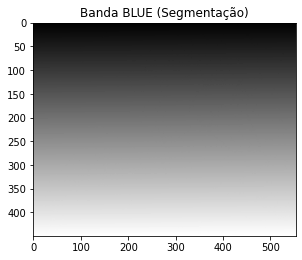

In [153]:
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title("Banda BLUE (Segmentação)")
plt.imshow(matriz_blue, cmap='gray')

In [154]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()

print(min_blue, max_blue)

0.0 61196.0


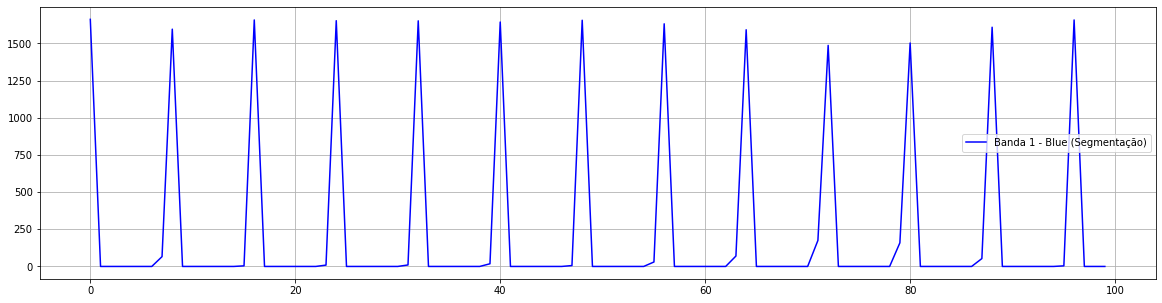

In [155]:
plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=100), 'b', label='Banda 1 - Blue (Segmentação)')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Banda 1 - Blue (Segmentação)')

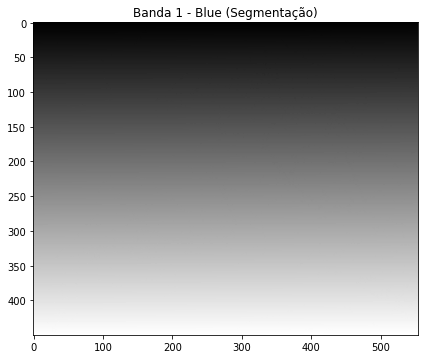

In [156]:
# obter as matrizes de pixels da banda
blue = band_blue.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(40, 10))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue (Segmentação)')

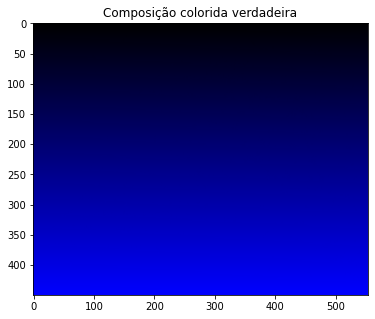

In [157]:
# 4.3.1. Composição colorida e Contraste
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
# Após segmentação - 1 banda
linhas = blue.shape[0]
colunas = blue.shape[1]

# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do RapidEye 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
# array_rgb[:, :, 0] = red / red.max()
# array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida (Segmentação)');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


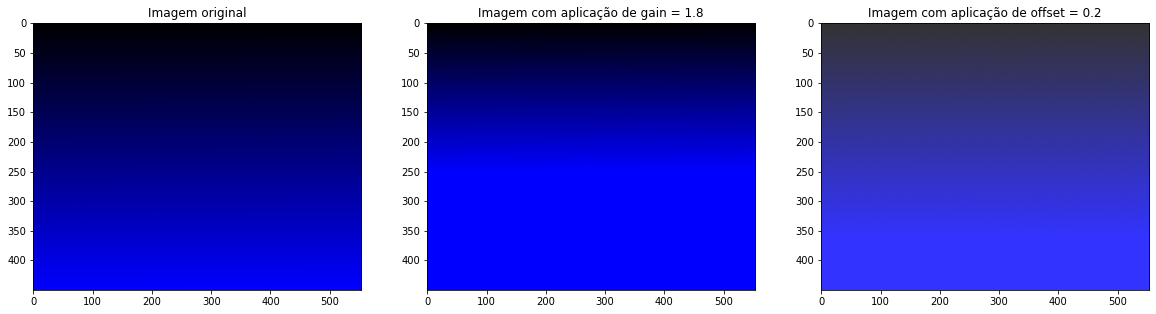

In [158]:
# Para realizar análises baseadas no comportamento espectral das imagens,
# técnicas de contraste devem ser evitadas.

# lembrando que os valores em array_rgb
# foram normalizados entre 0.0 e 1.0
gain = 1.8
offset = 0.2

# como no exemplo anterior criamos um
# array_rgb, vamos alterar uma cópia deste
# array com as operações de gain/offset
# para não comprometer os dados originais

array_rgb_gain = array_rgb.copy()
array_rgb_gain *= gain

array_rgb_offset = array_rgb.copy()
array_rgb_offset += offset

# apresentação dos resultados
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(array_rgb)
plt.title(f'Imagem original');

plt.subplot(132)
plt.imshow(array_rgb_gain)
plt.title(f'Imagem com aplicação de gain = {gain} (Segmentação)');

plt.subplot(133)
plt.imshow(array_rgb_offset)
plt.title(f'Imagem com aplicação de offset = {offset} (Segmentação)');

# pesquisar para fazer paletted/unique values - classify

# Imagem criada pela Classificação MLPClassifier

In [159]:
# https://gis.stackexchange.com/questions/267107/getting-indexerror-while-classifying-tif-using-gdal-python

In [160]:
class_fn = '/content/classified_mlpc.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
class_ds = gdal.Open(class_fn)
type(class_ds)

osgeo.gdal.Dataset

In [161]:
# obter os objetos com as informações da banda
band_blue  = class_ds.GetRasterBand(1)

print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))

Tipos de dados:
 - banda BLUE: Float32


In [162]:
matriz_blue = band_blue.ReadAsArray()

In [163]:
matriz_blue = matriz_blue.astype(float)

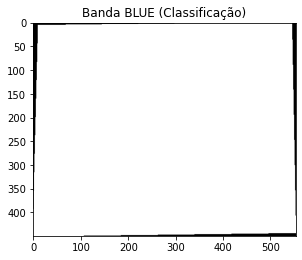

In [164]:
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title("Banda BLUE (Classificação)")
plt.imshow(matriz_blue, cmap='gray')

In [165]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()

print(min_blue, max_blue)

2.0 3.0


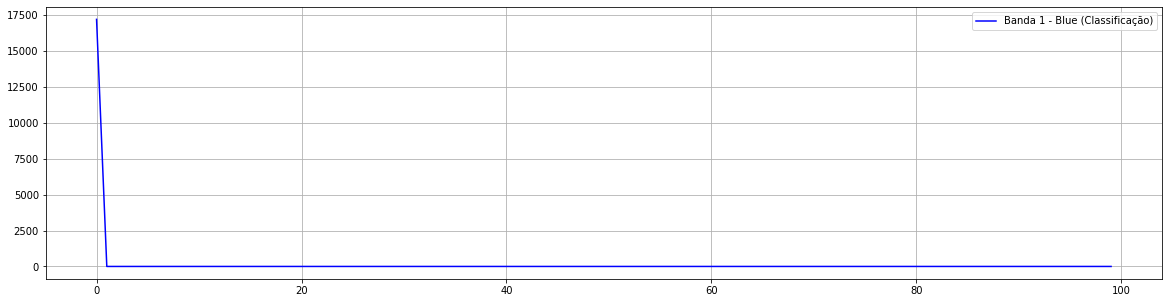

In [166]:
plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=100), 'b', label='Banda 1 - Blue (Classificação)')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Banda 1 - Blue (Classificação)')

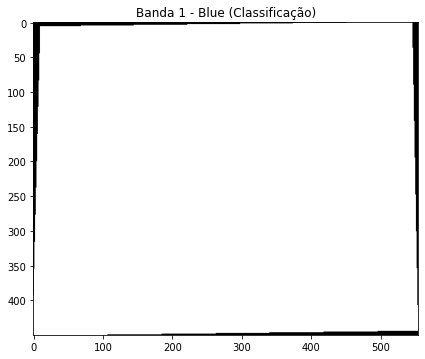

In [167]:
# obter as matrizes de pixels de cada banda
blue = band_blue.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(40, 10))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue (Classificação)')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


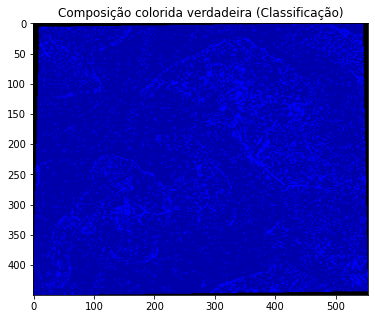

In [168]:
# 4.3.1. Composição colorida e Contraste
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
# Após segmentação - 1 banda
linhas = blue.shape[0]
colunas = blue.shape[1]

# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do RapidEye 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
# array_rgb[:, :, 0] = red / red.max()
# array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida (Classificação)');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


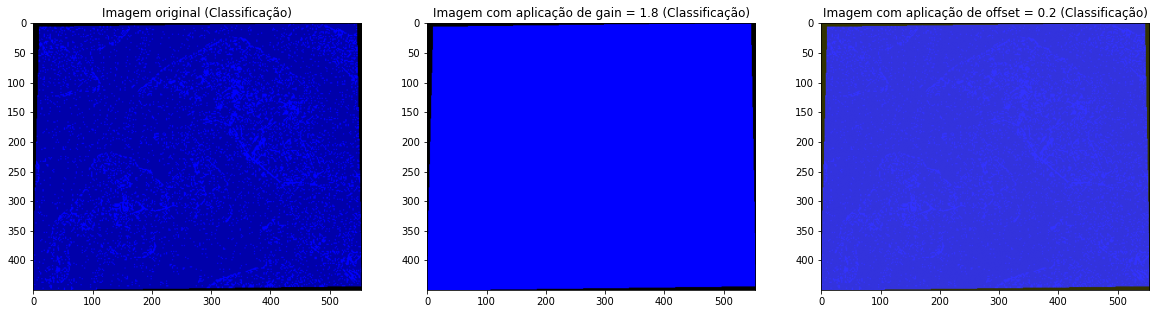

In [169]:
# Para realizar análises baseadas no comportamento espectral das imagens,
# técnicas de contraste devem ser evitadas.

# lembrando que os valores em array_rgb
# foram normalizados entre 0.0 e 1.0
gain = 1.8
offset = 0.2

# como no exemplo anterior criamos um
# array_rgb, vamos alterar uma cópia deste
# array com as operações de gain/offset
# para não comprometer os dados originais

array_rgb_gain = array_rgb.copy()
array_rgb_gain *= gain

array_rgb_offset = array_rgb.copy()
array_rgb_offset += offset

# apresentação dos resultados
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(array_rgb)
plt.title(f'Imagem original (Classificação)');

plt.subplot(132)
plt.imshow(array_rgb_gain)
plt.title(f'Imagem com aplicação de gain = {gain} (Classificação)');

plt.subplot(133)
plt.imshow(array_rgb_offset)
plt.title(f'Imagem com aplicação de offset = {offset} (Classificação)');

# Imagem criada pela Regressão MLPRegressor

In [170]:
regressor_fn = '/content/regressor_mlpr.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
regressor_ds = gdal.Open(regressor_fn)
type(regressor_ds)

osgeo.gdal.Dataset

In [171]:
# obter os objetos com as informações das bandas
band_blue  = regressor_ds.GetRasterBand(1)

print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))

Tipos de dados:
 - banda BLUE: Float32


In [172]:
matriz_blue = band_blue.ReadAsArray()
matriz_blue = matriz_blue.astype(float)

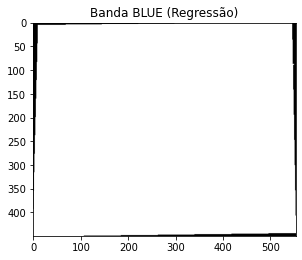

In [173]:
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title("Banda BLUE (Regressão)")
plt.imshow(matriz_blue, cmap='gray')

In [174]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()

print(min_blue, max_blue)

0.0 4.0


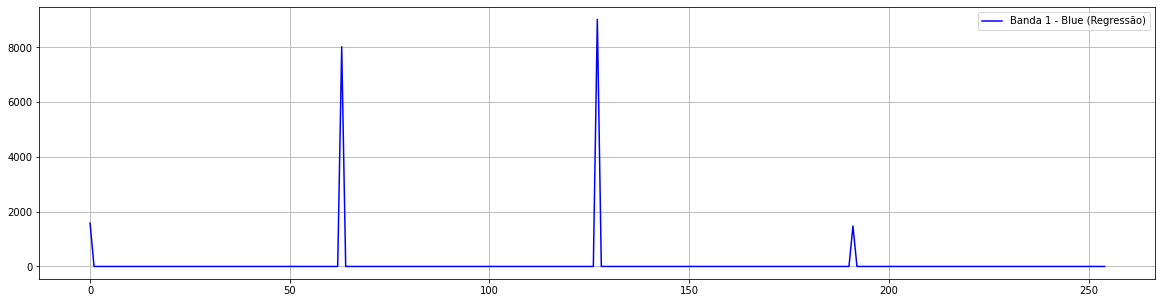

In [175]:
plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=255), 'b', label='Banda 1 - Blue (Regressão)')
plt.grid()
plt.legend()

# Este histograma apresenta as informações divididas em 100 partes, ou buckets. 
# Portanto, o eixo x não contém os valores de números digitais originais da imagem,
# e sim os valores espaçados no intervalo definido pelos parâmetros min e max. (buckets=255?)

Text(0.5, 1.0, 'Banda 1 - Blue (Regressão)')

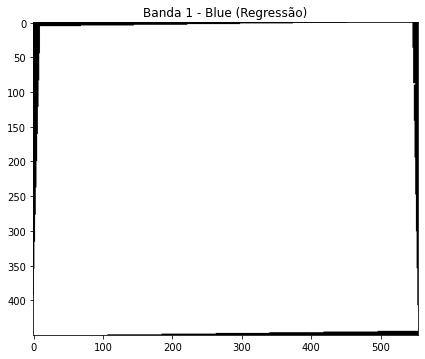

In [176]:
# obter as matrizes de pixels de cada banda
blue = band_blue.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(40, 10))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue (Regressão)')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


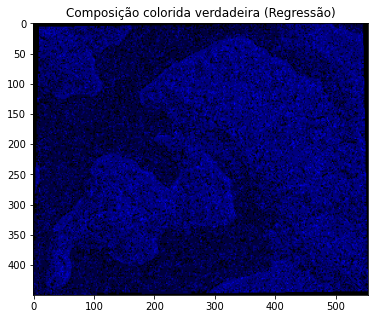

In [177]:
# 4.3.1. Composição colorida e Contraste
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
# Após segmentação - 1 banda
linhas = blue.shape[0]
colunas = blue.shape[1]

# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do RapidEye 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
# array_rgb[:, :, 0] = red / red.max()
# array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida (Regressão)');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


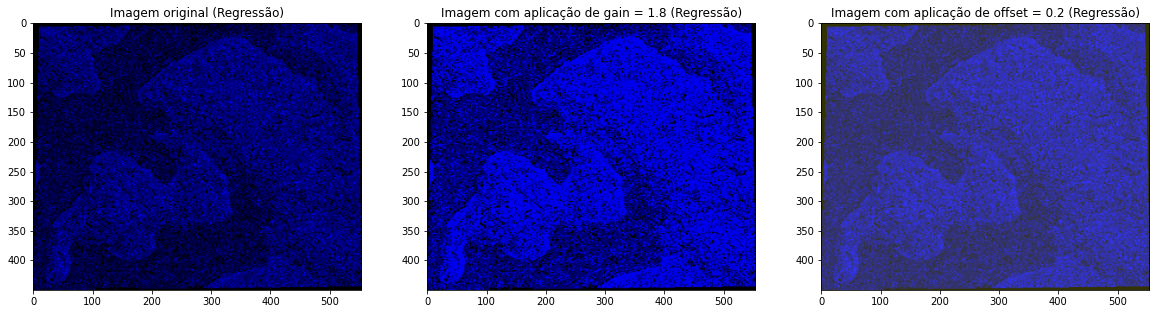

In [178]:
# Para realizar análises baseadas no comportamento espectral das imagens,
# técnicas de contraste devem ser evitadas.

# lembrando que os valores em array_rgb
# foram normalizados entre 0.0 e 1.0
gain = 1.8
offset = 0.2

# como no exemplo anterior criamos um
# array_rgb, vamos alterar uma cópia deste
# array com as operações de gain/offset
# para não comprometer os dados originais

array_rgb_gain = array_rgb.copy()
array_rgb_gain *= gain

array_rgb_offset = array_rgb.copy()
array_rgb_offset += offset

# apresentação dos resultados
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(array_rgb)
plt.title(f'Imagem original (Regressão)');

plt.subplot(132)
plt.imshow(array_rgb_gain)
plt.title(f'Imagem com aplicação de gain = {gain} (Regressão)');

plt.subplot(133)
plt.imshow(array_rgb_offset)
plt.title(f'Imagem com aplicação de offset = {offset} (Regressão)');

# Imagem Original

In [179]:
################### INFOS BANDS ORIGINAL ################################

# obter os objetos com as informações das bandas
band_blue  = naip_ds.GetRasterBand(1)
band_green = naip_ds.GetRasterBand(2)
band_red = naip_ds.GetRasterBand(3)
band_nir = naip_ds.GetRasterBand(4)
print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))
print(" - banda GREEN:", gdal.GetDataTypeName(band_green.DataType))
print(" - banda RED:", gdal.GetDataTypeName(band_red.DataType))
print(" - banda NIR:", gdal.GetDataTypeName(band_nir.DataType))

Tipos de dados:
 - banda BLUE: Float32
 - banda GREEN: Float32
 - banda RED: Float32
 - banda NIR: Float32


In [180]:
matriz_red = band_red.ReadAsArray()
matriz_nir = band_nir.ReadAsArray()

In [181]:
matriz_red = matriz_red.astype(float)
matriz_nir = matriz_nir.astype(float)

# geracao de array derivado das bandas
matriz_ndvi = (matriz_nir - matriz_red) / \
              (matriz_nir + matriz_red + 0.000000001)

# mostrar as dimensoes e tipo de dado da matriz de saida
print(matriz_ndvi.shape)
print(matriz_ndvi.dtype)

(450, 554)
float64


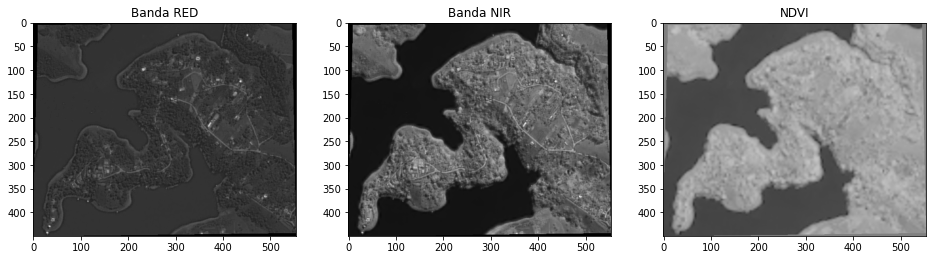

In [182]:
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title("Banda RED")
plt.imshow(matriz_red, cmap='gray')

plt.subplot(132)
plt.title("Banda NIR")
plt.imshow(matriz_nir, cmap='gray')

plt.subplot(133)
plt.title("NDVI")
plt.imshow(matriz_ndvi, cmap='gray', vmin=-1.0, vmax=1.0)

In [183]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()
min_green, max_green = band_green.ComputeRasterMinMax()
min_red, max_red = band_red.ComputeRasterMinMax()
min_nir, max_nir = band_nir.ComputeRasterMinMax()
print(min_nir, max_nir)

45.4295768737793 1570.8221435546875


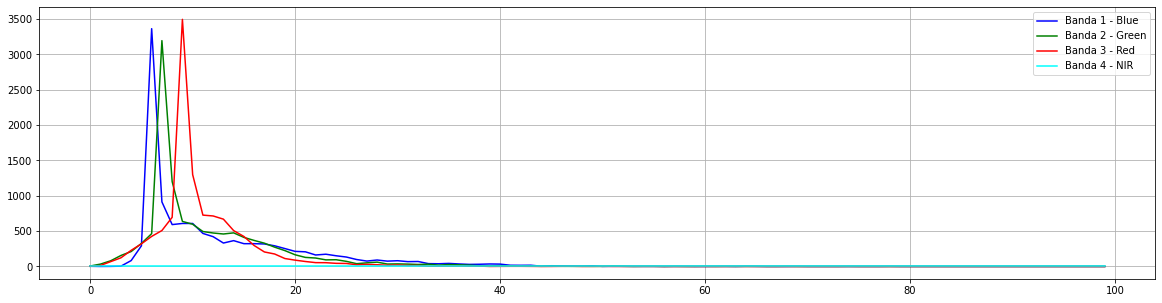

In [184]:
# a função GetHistogram precisa de intervalos
# mínimos e máximos de pixels para cada banda (min/max)
# e também a informação de divisões do gráfico (buckets)

plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=100), 'b', label='Banda 1 - Blue')
plt.plot(band_green.GetHistogram(min=min_green, max=max_green, buckets=100), 'g', label='Banda 2 - Green')
plt.plot(band_red.GetHistogram(min=min_red, max=max_red, buckets=100), 'r', label='Banda 3 - Red')
plt.plot(band_nir.GetHistogram(min=min_nir, max=MAXDIMS, buckets=100), 'cyan', label='Banda 4 - NIR')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Banda 4 - NIR')

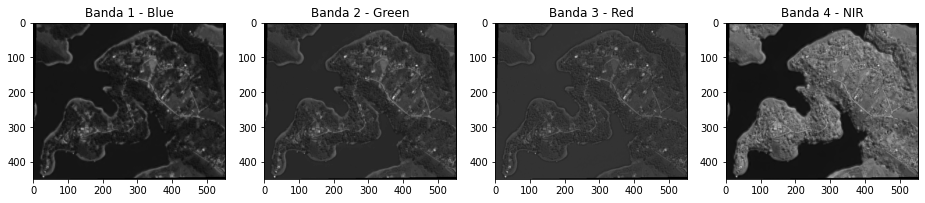

In [185]:
# obter as matrizes de pixels de cada banda
blue = band_blue.ReadAsArray()
green = band_green.ReadAsArray()
red = band_red.ReadAsArray()
nir = band_nir.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue')
plt.subplot(152)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')
plt.subplot(153)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(154)
plt.imshow(nir, cmap='gray')
plt.title('Banda 4 - NIR')

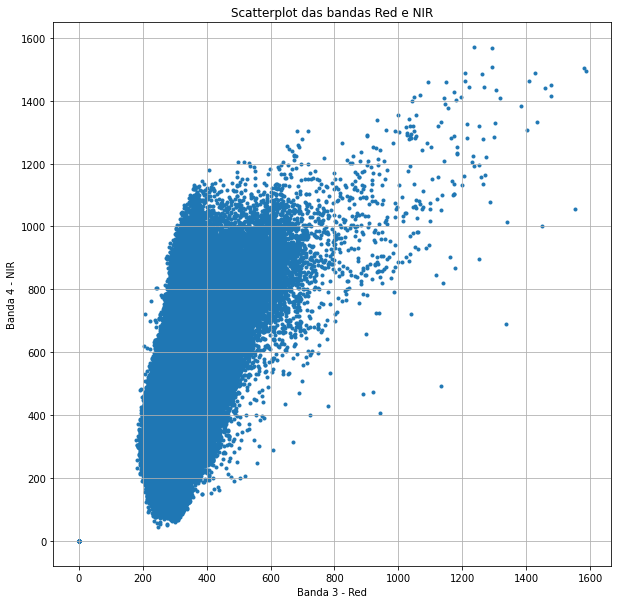

In [186]:
# obter os vetores de 1 dimensão de cada banda
vetor_red = red.flatten()
vetor_nir = nir.flatten()

# construir o gráfico com o scatterplot
plt.figure(figsize=(10, 10))

plt.scatter(vetor_red, vetor_nir, marker='.')
plt.xlabel("Banda 3 - Red")
plt.ylabel("Banda 4 - NIR")
plt.title("Scatterplot das bandas Red e NIR")
plt.grid();